<a href="https://colab.research.google.com/github/duarte3333/Machine_Learning/blob/main/task1_imageanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import tensorflow.keras.backend as K
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

################# PRE PROCESSING ####################
def load_data():
    """ Load the training and test data. """
    #2352 elements each image: 2352 = pixels x pixels x 3 (RGB)
    X = np.load('Xtrain_Classification1.npy') #6254 x 2352. 2352 = pixels x pixels x 3 (RGB). Training set is inbalanced, different number of samples for each class
    y = np.load('ytrain_Classification1.npy') #6254. 1D vector
    X_t = np.load('Xtest_Classification1.npy') #1764 x 2352. Has data from two distinct sources
    return X, y, X_t

def preprocess_data(X, X_t):
    """ This function scale the training data to be in the range [0, 1]
    and the data type to float32 for numerical stability """
    Xs = (X).astype('float32') / np.max(X) #Scale down data [0,1]
    Xs_test = (X_t).astype('float32') / np.max(X)
    return Xs, Xs_test

def encode_data(y, Xs, y_test, Xs_test):
    """ Enconde data function """
    train_labels = keras.utils.to_categorical(y,num_classes=2) #One-hot enconding: 6254 x 2 matrix that is 0 or 1 depending on class
    test_labels = keras.utils.to_categorical(y_test,num_classes=2)
    train_images = np.reshape(Xs, (len(Xs[:,0]),28,28,3)) #4D array. number of images x width x height x color
    test_images = np.reshape(Xs_test, (len(Xs_test[:,0]), 28, 28, 3))
    return train_labels, train_images, test_images, test_labels

def shuffle_data(train_images, train_labels):
    permutation = np.random.permutation(len(train_images))
    train_images_s = train_images[permutation]
    train_labels_s = train_labels[permutation]
    return train_images_s, train_labels_s

def split_data(train_images_s, train_labels_s):
    X_train, X_validation, y_train, y_validation = train_test_split(train_images_s, train_labels_s, test_size=0.2)
    print("Split X_train: ", X_train.shape)
    print("Split y_train: ", y_train.shape)
    return X_train, X_validation, y_train, y_validation

def plot_images(number_images,X_train):
  '''Plot a user defined number of images from X_train. Only really works for 10 images'''
  number_images = 10
  plt.figure(figsize=(12, 6))
  for i in range(number_images):
      plt.subplot(2, 5, i + 1)
      plt.imshow(X_train[i])
      plt.title(f"Image {i+1}")
      plt.axis('off')
  plt.tight_layout()
  plt.show()

######################## NEURAL NETWORK #####################################

#Building MLP neural network, Sequential (linear stack of Layers); kernel size 3 by 3 is normal in image data
#padding keeps images in the same size; poolsize and strides -> Check notes on notion on maxpooling
def Convolution_NN_1():
    cnn = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding= 'same', input_shape = (28,28,3)),
        keras.layers.MaxPool2D(pool_size =(2,2), strides=2),
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation = 'relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
        keras.layers.Flatten(), #Flatten is always needed before using fully connected layer (Dense) for output
        keras.layers.Dense(units=2, activation='softmax')
    ])
    #cnn.summary() #See created neural network
    return cnn

def Convolution_NN_2(): #another model
    cnn_model1 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3),1, activation='relu', input_shape=(28, 28, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3),1, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3),1, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2,activation='softmax')
    ])
    return cnn_model1

def Convolution_NN_3(): 
    cnn_model2 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28, 28, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(2, activation='softmax')
    ])
    return cnn_model2

def Convolution_NN_4(): #Alex
    model_img= keras.Sequential()
    model_img.add(keras.layers.Conv2D(16, kernel_size=(3, 3),padding="same", activation='relu', input_shape=(28,28,3)))
    model_img.add(keras.layers.BatchNormalization())
    model_img.add(keras.layers.Conv2D(16, kernel_size=(3, 3),padding="same", activation='relu', input_shape=(28,28,3), kernel_regularizer='l2'))
    model_img.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(keras.layers.Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))
    model_img.add(keras.layers.BatchNormalization())
    model_img.add(keras.layers.Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))
    model_img.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(keras.layers.Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu', kernel_regularizer='l2'))
    model_img.add(keras.layers.Flatten())
    model_img.add(keras.layers.Dense(128, activation='relu')) #, activity_regularizer='l2',bias_regularizer='l2'
    model_img.add(keras.layers.Dropout(.2))
    model_img.add(keras.layers.Dense(128, activation='relu')) #activity_regularizer='l2',bias_regularizer='l2')
    model_img.add(keras.layers.Dropout(.2))
    model_img.add(keras.layers.Dense(128, activation='relu')) #activity_regularizer='l2',bias_regularizer='l2')
    model_img.add(keras.layers.Dense(2, activation='softmax'))
    # model_img.compile(
    #         optimizer = optimizer_string,
    #         # Optimizer: use either ADAM or SGDM
    #         # Loss function to minimize
    #         loss = loss_string,
    #         # List of metrics to monitor
    #         metrics=[keras.metrics.F1Score(), sensitivity_custom ,balanced_accuracy_custom, balanced_accuracy_enunciado  ] #keras.metrics.Precision(),keras.metrics.Recall()
    #     )
    return model_img

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt = y_pred * y_true + (1 - y_pred) * (1 - y_true) # Get the "modulated" probabilities 
        return -K.sum(alpha * K.pow(1.0 - pt, gamma) * K.log(pt + K.epsilon()))
    return focal_loss_fixed

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred = K.cast(K.round(y_pred), 'float32')  # Cast y_pred to float32
    
    # Compute precision, recall
    precision = K.sum(y_true * y_pred) / (K.sum(y_pred) + K.epsilon())
    recall = K.sum(y_true * y_pred) / (K.sum(y_true) + K.epsilon())

    # Compute F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def specificity_custom(y_pred_onehot, y_true_onehot): 
    """ How well can identify true negatives """
    y_pred = tf.argmax(y_pred_onehot, axis=1)
    y_true = tf.argmax(y_true_onehot, axis=1)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = tf.reduce_sum(tf.cast(neg_y_true, dtype=tf.float32) * tf.cast(y_pred, dtype=tf.float32))  # false positives
    tn = tf.reduce_sum(tf.cast(neg_y_true, dtype=tf.float32) * tf.cast(neg_y_pred, dtype=tf.float32))  # true negatives
    if fp + tn == 0:
        return 0.0
    return tn / (tn + fp)

# One hot enconding -> ["apple", "banana", "cherry"].
# "apple" becomes [1, 0, 0], "banana" becomes [0, 1, 0], "cherry" becomes [0, 0, 1]
def sensitivity_custom(y_pred_onehot, y_true_onehot): 
    """ How well can identify true positives """
    y_pred = tf.argmax(y_pred_onehot, axis=1) # sensitivity(recall)
    y_true = tf.argmax(y_true_onehot, axis=1)
    neg_y_pred = 1 - y_pred
    fn = tf.reduce_sum(tf.cast(neg_y_pred, dtype=tf.float32) * tf.cast(y_true, dtype=tf.float32))
    tp = tf.reduce_sum(tf.cast(y_true, dtype=tf.float32) * tf.cast(y_pred, dtype=tf.float32))
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def balanced_accuracy_custom(y_pred_onehot, y_true_onehot):
    """ Average of specificity and sensitivity """
    specificity_val = specificity_custom(y_pred_onehot, y_true_onehot)
    sensitivity_val = sensitivity_custom(y_pred_onehot, y_true_onehot)
    return (specificity_val + sensitivity_val) / 2

#BACC , F1 , Confusion matrix, Classification_report
def Compile_MLP_categorical_crossentropy(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[keras.metrics.F1Score(), sensitivity_custom ,\
                                                                                        balanced_accuracy_custom ]) #accuracy only used for balanced data

def Compile_MLP_focal_loss(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(), metrics=[keras.metrics.F1Score()])
    
def Compile_MLP_binary_crossentropy(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[keras.metrics.F1Score()])

def class_weights(y_train):
    y_train_int = tf.argmax(y_train, axis=1)
    y_train_int_np = y_train_int.numpy()
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_int_np), y=y_train_int_np)
    class_weights = {i: weights[i] for i in range(len(weights))}
    return class_weights

def train_model_class_weights(MLP, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #Patince is the number of epochs whithout improvements
    history = MLP.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                   batch_size=512, epochs=200, shuffle=True, verbose=in_verbose, callbacks=[early_stop],
                   class_weight=class_weights(y_train))
    return history

def train_model(MLP, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #Patince is the number of epochs whithout improvements
    history = MLP.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                   batch_size=512, epochs=200, shuffle=True, verbose=in_verbose, callbacks=[early_stop])
    return history

######################## RESULTS ############################

def make_predictions(MLP, test_images):
    predictions = MLP.predict(x = test_images, batch_size = 200, verbose=0) #Returns probability of each class
    rounded_predictions= np.argmax(predictions, axis=-1) #Rounds it to 0 or 1
    return rounded_predictions
    
def plot(history):
    plt.figure(figsize=(15, 5))  # Increase the figure size

    # Create the first subplot (Loss)
    plt.subplot(2, 2, 1)  # Create a subplot with 1 row and 3 columns, and select the first subplot
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Create the second subplot (F1 Score)
    plt.subplot(2, 2, 2)  # Select the second subplot
    plt.plot(history.history['f1_score'], 'g', label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], 'r', label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    # Create the third subplot (Balanced Accuracy)
    plt.subplot(2, 2, 3)  # Select the third subplot
    plt.plot(history.history['balanced_accuracy_custom'], 'b', label='Training Balanced Accuracy')
    plt.plot(history.history['val_balanced_accuracy_custom'], 'y', label='Validation Balanced Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy')
    plt.title('Training and Validation Balanced Accuracy')
    plt.legend()
    
    # Create the third subplot (Balanced Accuracy)
    plt.subplot(2, 2, 4)  # Select the third subplot
    plt.plot(history.history['sensitivity_custom'], 'b', label='Training Sensitivity Accuracy')
    plt.plot(history.history['val_sensitivity_custom'], 'y', label='Validation Sensitivity Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Sensitivity Accuracy')
    plt.title('Training and Validation Sensitivity Accuracy')
    plt.legend()

    plt.tight_layout()  # Ensure that the subplots don't overlap
    plt.show()


def check_imbalance(MLP, test_images):
    rounded_predictions = make_predictions(MLP, test_images) #Make predictions
    cont_0 = 0
    for i in rounded_predictions: #Visualize imbalance in training data
        if i == 0:
            cont_0 += 1
    print(cont_0, len(test_images[:,0])-cont_0) #Big difference between classes due to imbalanced training set

def check_results(history):
    plot(history)
    print("Train - Loss: {:.4f}".format(history.history['loss'][-1]))
    print("Test  - Val Loss: {:.4f}".format(np.mean(history.history['val_loss'][-1])))
    train_f1_score = np.mean(history.history['f1_score'])
    val_f1_score = np.mean(history.history['val_f1_score'])
    print("Train - Mean F1 Score: {:.4f}".format(train_f1_score))
    print("Test - Mean Val F1 Score: {:.4f}".format(val_f1_score))
    train_sensitivity = history.history['sensitivity_custom'][-1]
    val_sensitivity = history.history['val_sensitivity_custom'][-1]
    print("Train - Final Sensitivity: {:.4f}".format(train_sensitivity))
    print("Test - Final Val Sensitivity: {:.4f}".format(val_sensitivity))
    train_balanced_accuracy = history.history['balanced_accuracy_custom'][-1]
    val_balanced_accuracy = history.history['val_balanced_accuracy_custom'][-1]
    print("Train - Final Balanced Accuracy: {:.4f}".format(train_balanced_accuracy))
    print("Test - Final Val Balanced Accuracy: {:.4f}".format(val_balanced_accuracy))


def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy ):
    file_name_model=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    file_name_history=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    model_fitted.save(file_name_model)
    np.save(file_name_history,model_history.history)
    
X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)
X_train_shuffle, y_train_shuffle = shuffle_data(X_train, y_train)
train_labels, train_images, test_images, test_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
#plot_images(10, train_images)

Split X_train:  (5003, 2352)
Split y_train:  (5003,)


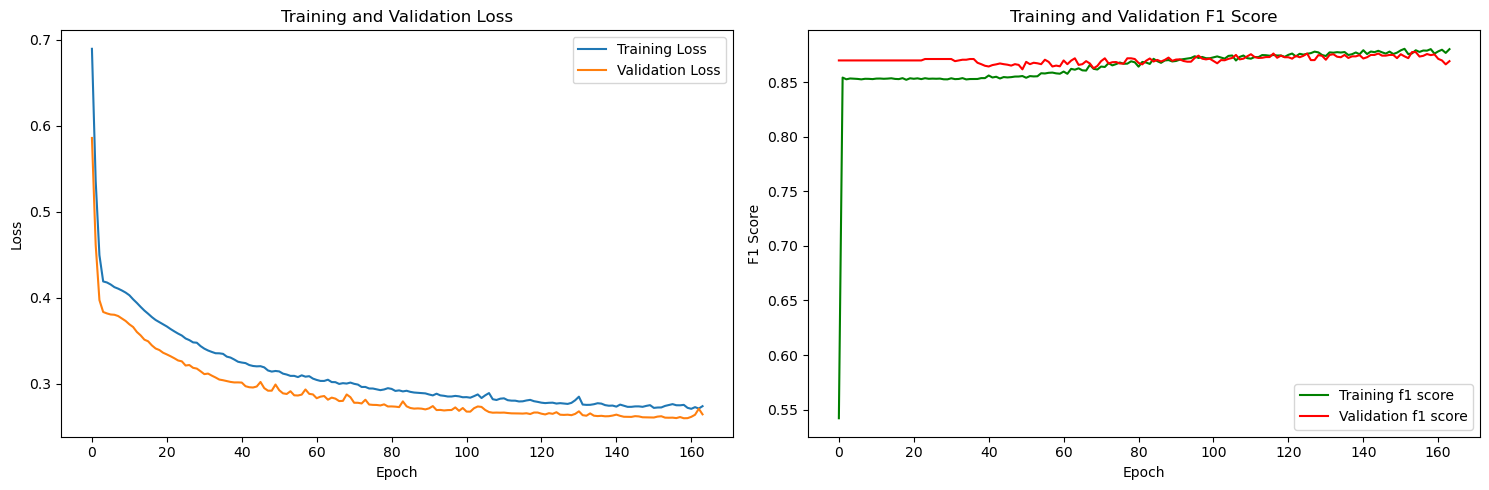

Train - Mean loss:  0.2739468216896057
Test  - Mean Val loss:  0.2644677758216858
Train - Mean F1 Score:  0.8638215344853517
Test - Mean Val F1 Score:  0.8705436234794012
1191 60


In [27]:
########## FIRST APPROACH - MLP with imbalanced data ###################

#Compiled with categorical_crossentropy without class weights
NN_model = Convolution_NN_1()
Compile_MLP_categorical_crossentropy(NN_model)
history = train_model(NN_model, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(NN_model)

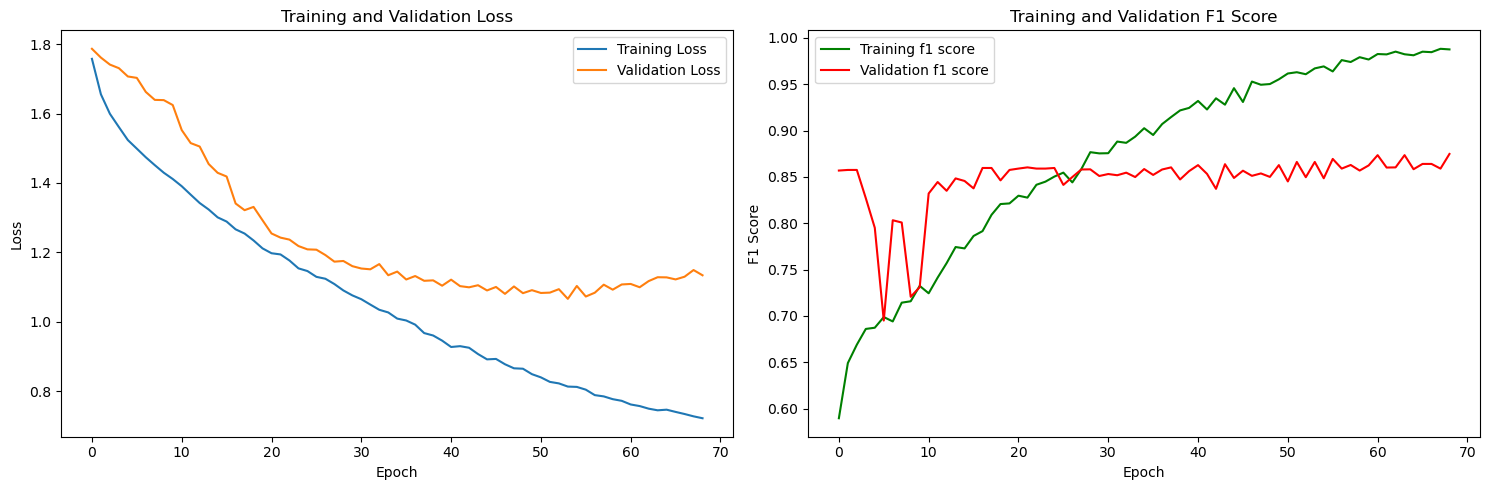

Train - Mean loss:  0.722052812576294
Test  - Mean Val loss:  1.1339689493179321
Train - Mean F1 Score:  0.870985766251882
Test - Mean Val F1 Score:  0.8466639717419943
1091 160


In [47]:
#Categorical crossentropy with classweights - FIRST CNN
NN_model_2 = Convolution_NN_4()
Compile_MLP_categorical_crossentropy(NN_model_2)
history = train_model_class_weights(NN_model_2, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(NN_model_2)

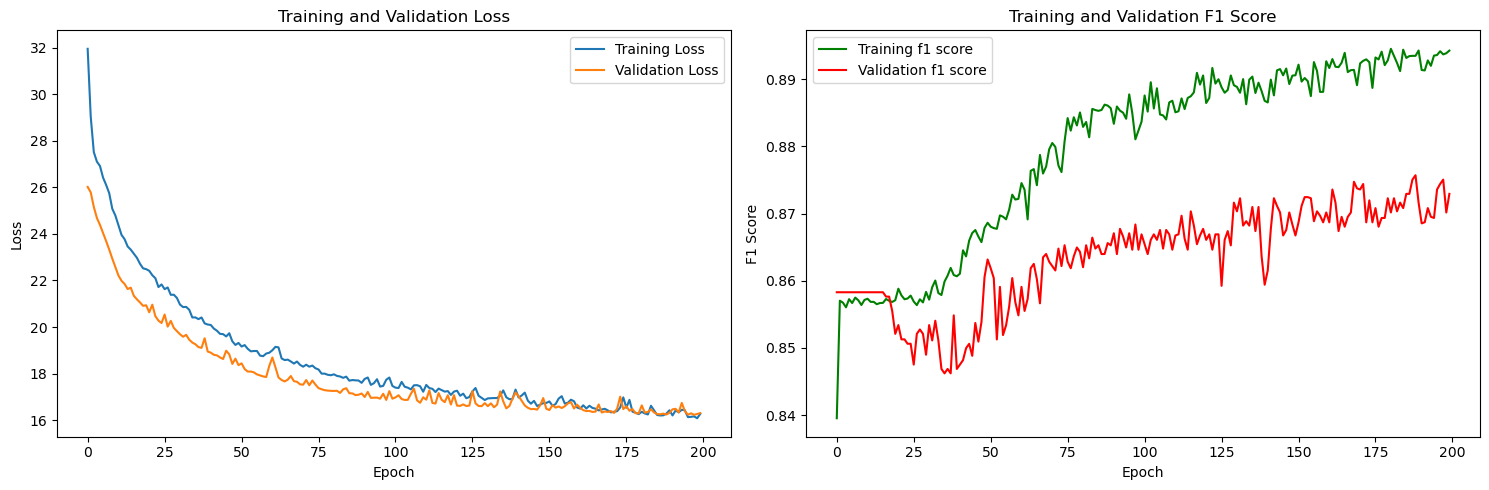

Train - Mean loss:  16.268457412719727
Test  - Mean Val loss:  16.301774978637695
Train - Mean F1 Score:  0.8796625506877899
Test - Mean Val F1 Score:  0.8635699990391731
1144 107


In [7]:
# Focal loss with classweights
# Assign higher weights to the misclassified examples of the minority class
NN_model_3 = Convolution_NN_1()
Compile_MLP_focal_loss(NN_model_3)
history = train_model_class_weights(NN_model_3, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(NN_model_3)
# Train MLP model, # Note: Try 'SparseCategoricalCrossEntropy' as loss function.

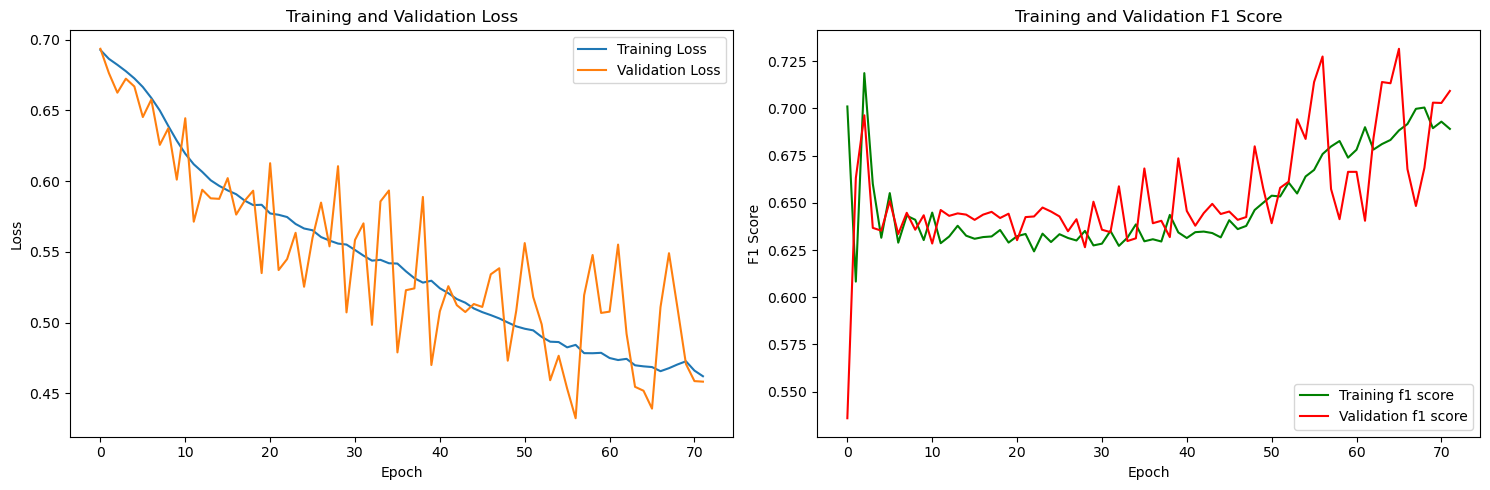

Train - Mean loss:  0.46200233697891235
Test  - Mean Val loss:  0.45816901326179504
Train - Mean F1 Score:  0.6499685984518793
Test - Mean Val F1 Score:  0.6545135958327187
842 409


In [19]:
#Binary crossentropy with class weights

NN_model_4 = Convolution_NN_1()
Compile_MLP_binary_crossentropy(NN_model_4)
history = train_model_class_weights(NN_model_4, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(NN_model_4)

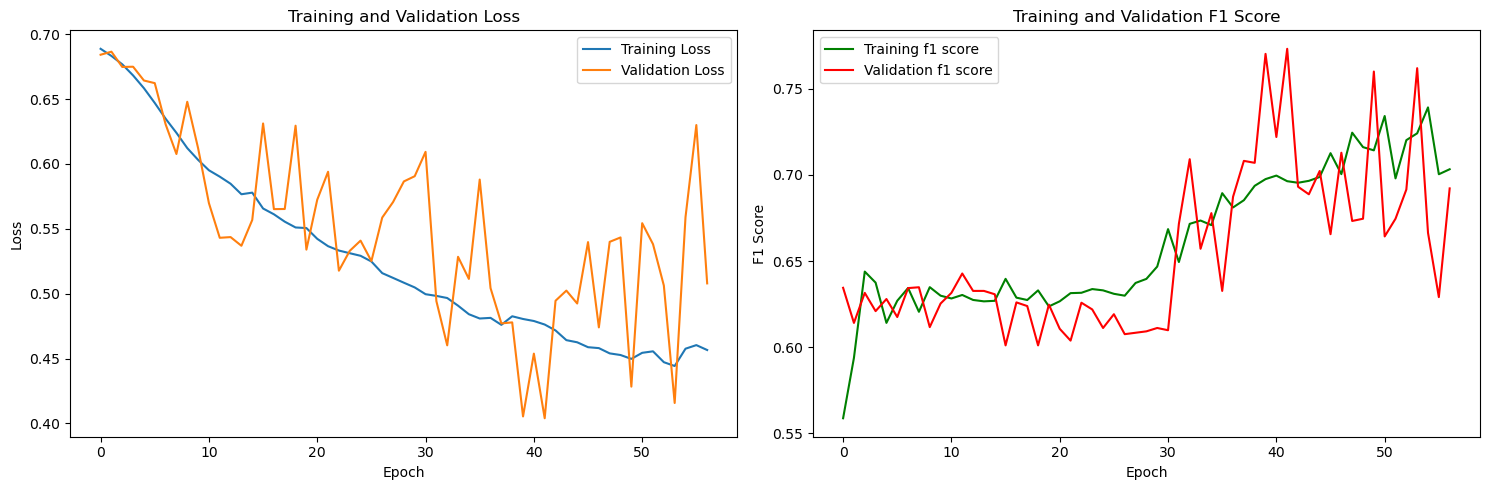

Train - Mean loss:  0.4565980136394501
Test  - Mean Val loss:  0.5079601407051086
Train - Mean F1 Score:  0.6610691714705083
Test - Mean Val F1 Score:  0.6544494252455862
932 319


In [12]:
#ANOTHER Compiled with categorical crossentropy with class weights

NN_model_5 = Convolution_NN_2()
Compile_MLP_categorical_crossentropy(NN_model_5)
history = train_model_class_weights(NN_model_5, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(NN_model_5)

In [ ]:
#Simple NN1 NN with categorical crossentropy and class weights
NN_model_1_1 = Convolution_NN_1()
Compile_MLP_categorical_crossentropy(NN_model_1_1)
history = train_model_class_weights(NN_model_1_1, train_images, train_labels, test_images, test_labels, 0)

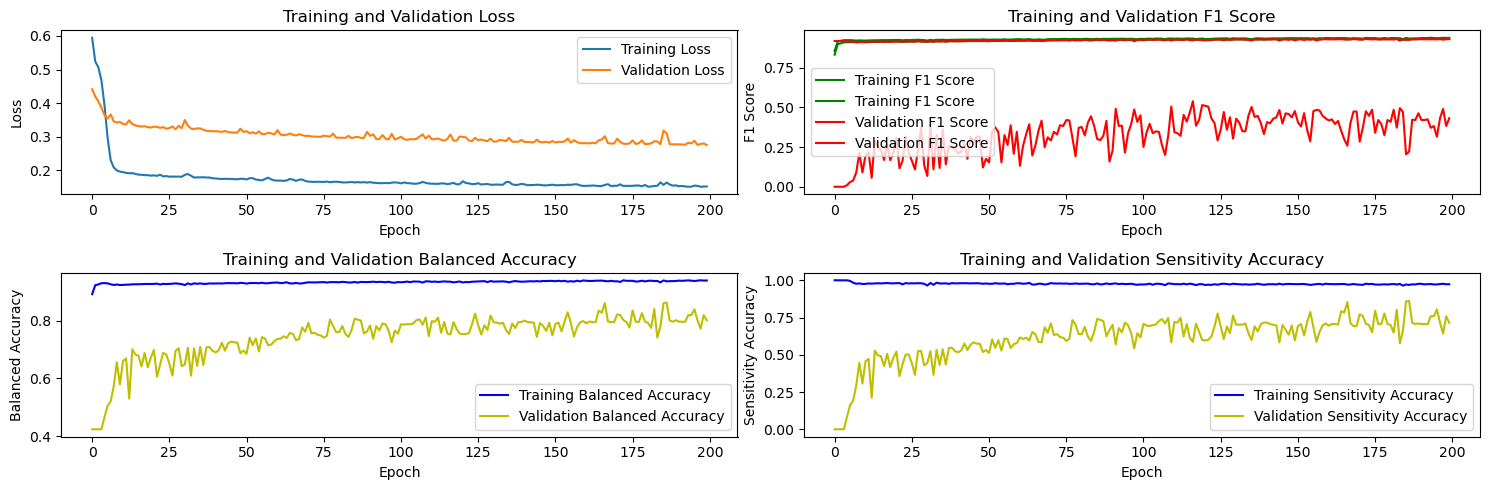

Train - Loss: 0.1512
Test  - Val Loss: 0.2750
Train - Mean F1 Score: 0.9271
Test - Mean Val F1 Score: 0.6268
Train - Final Sensitivity: 0.9734
Test - Final Val Sensitivity: 0.7149
Train - Final Balanced Accuracy: 0.9386
Test - Final Val Balanced Accuracy: 0.8011
1165 86


In [11]:
check_results(history)
check_imbalance(NN_model_1_1, test_images)

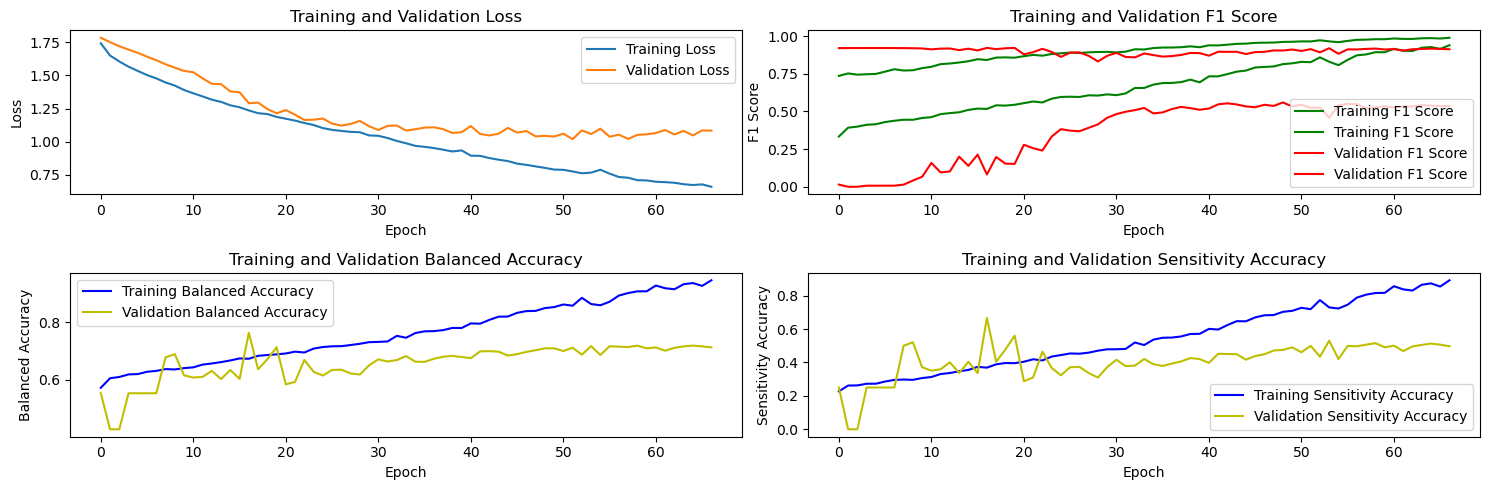

Train - Loss: 0.6599
Test  - Val Loss: 1.0837
Train - Mean F1 Score: 0.7811
Test - Mean Val F1 Score: 0.6343
Train - Final Sensitivity: 0.8920
Test - Final Val Sensitivity: 0.4972
Train - Final Balanced Accuracy: 0.9456
Test - Final Val Balanced Accuracy: 0.7121
1577 301


In [145]:
#Compiled NN of Alex with categorical crossentropy and class weights
NN_model_6 = Convolution_NN_4()
Compile_MLP_categorical_crossentropy(NN_model_6)
history = train_model_class_weights(NN_model_6, train_images, train_labels, test_images, test_labels, 0)
check_results(history, test_images)
check_imbalance(NN_model_6)

Split X_train:  (7512, 2352)
Split y_train:  (7512, 1)


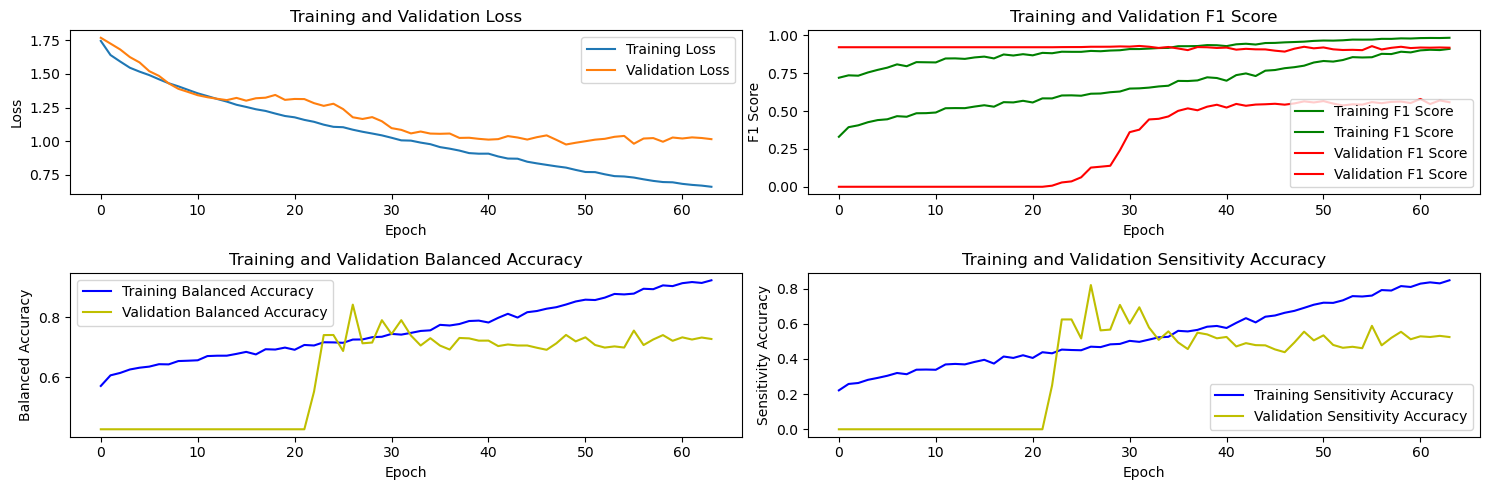

Train - Loss: 0.6605
Test  - Val Loss: 1.0147
Train - Mean F1 Score: 0.7802
Test - Mean Val F1 Score: 0.6048
Train - Final Sensitivity: 0.8478
Test - Final Val Sensitivity: 0.5249
Train - Final Balanced Accuracy: 0.9231
Test - Final Val Balanced Accuracy: 0.7277
1596 282


In [144]:
############### SECOND APPROACH - BALANCED DATA #############

#Create ways to do data augmentation
def data_augmentation(x, y, augmentation_factor):
    #augmentation_factor is total nr_samples after augmentation / original nr of samples (always >1)
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_train_reshape = np.reshape(x,(x.shape[0],28,28,3))
    data_generator.fit(X_train_reshape)
    #creating arrays of new data/augmented data 
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])
    #generating data
  
    for batch_x, batch_y in data_generator.flow(X_train_reshape, y, batch_size=32, seed=500): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] > (x.shape[0])*(augmentation_factor-1): #stops when generated enougth data to satisfy the augmentation factor
            break
            
    
    x_train_aug=np.vstack([x, x_augmented])
    y_train_aug=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])
    return x_train_aug, y_train_aug

X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)
X_train_shuffle, y_train_shuffle = shuffle_data(X_train, y_train)
train_balanced_x, train_balanced_y = data_augmentation(X_train_shuffle, y_train_shuffle)
train_labels, train_images, test_images, test_labels = encode_data(train_balanced_y, train_balanced_x, y_validation, X_validation)

# Load your data
X, y, X_t = load_data()
new_Xtrain, new_Ytrain = data_augmentation(X, y, 1.5)
Xs, Xs_test = preprocess_data(new_Xtrain, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, new_Ytrain)
X_train_shuffle, y_train_shuffle = shuffle_data(X_train, y_train)
train_labels, train_images, test_images, test_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
NN_aug = Convolution_NN_4()
Compile_MLP_categorical_crossentropy(NN_aug)
#history = NN_aug.fit(train_images, train_labels, validation_data=(test_images, test_labels), batch_size=512, epochs=200, shuffle=True, verbose=0)
history = train_model_class_weights(NN_aug, train_images, train_labels, test_images, test_labels, 0)
# Check the results and balance
check_results(history)
check_imbalance(NN_aug, test_images)

Split X_train:  (5003, 2352)
Split y_train:  (5003,)


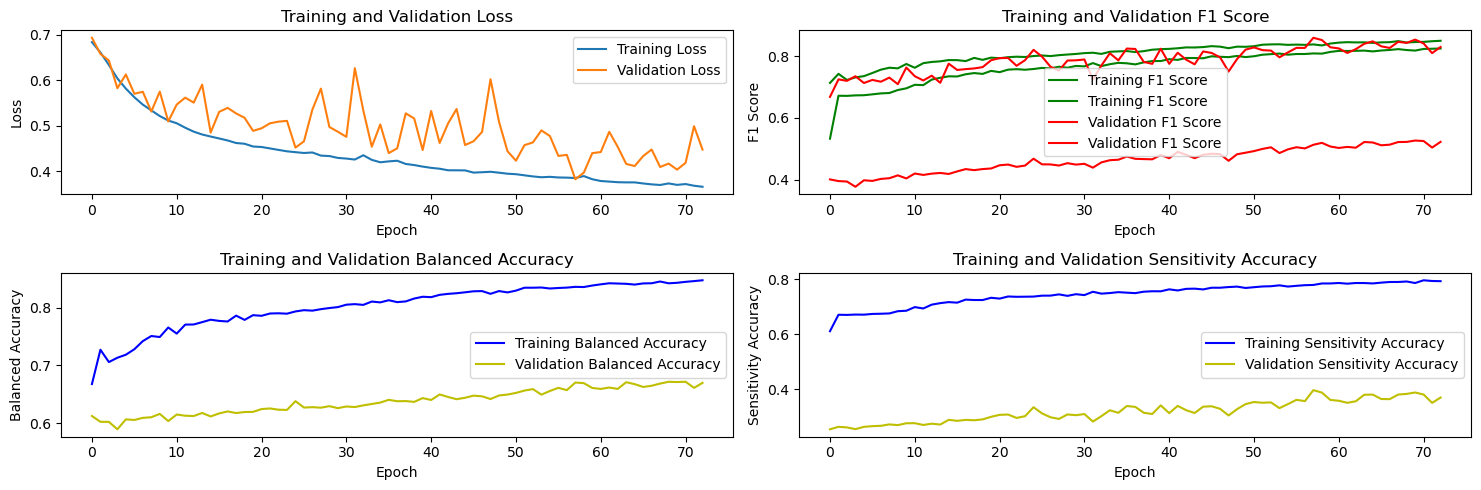

Train - Loss: 0.3659
Test  - Val Loss: 0.4475
Train - Mean F1 Score: 0.7882
Test - Mean Val F1 Score: 0.6261
Train - Final Sensitivity: 0.7931
Test - Final Val Sensitivity: 0.3704
Train - Final Balanced Accuracy: 0.8471
Test - Final Val Balanced Accuracy: 0.6697
886 365


In [12]:
# Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE

#It uses SMOTE to oversample the minority class, adjusting the number of samples for each class.
def oversample_data(train_images, train_labels):
    smote = SMOTE(sampling_strategy='auto')
    train_images_reshaped = train_images.reshape(-1, 28*28*3)  # Reshape images for SMOTE
    train_images_oversampled_reshaped, train_labels_oversampled = smote.fit_resample(train_images_reshaped, train_labels)
    train_images_oversampled = train_images_oversampled_reshaped.reshape(-1, 28, 28, 3)  # Reshape back to original shape
    return train_images_oversampled, train_labels_oversampled

X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = oversample_data(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)
train_labels, train_images, test_images, test_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
#plot_images(10, train_images_s_oversampled)

MLP_oversampled = Convolution_NN_1()
Compile_MLP_categorical_crossentropy(MLP_oversampled)
history_oversampled = train_model_class_weights(MLP_oversampled, train_images, train_labels, test_images, test_labels, 0)
check_results(history_oversampled)
check_imbalance(MLP_oversampled, test_images)

Split X_train:  (5003, 2352)
Split y_train:  (5003,)


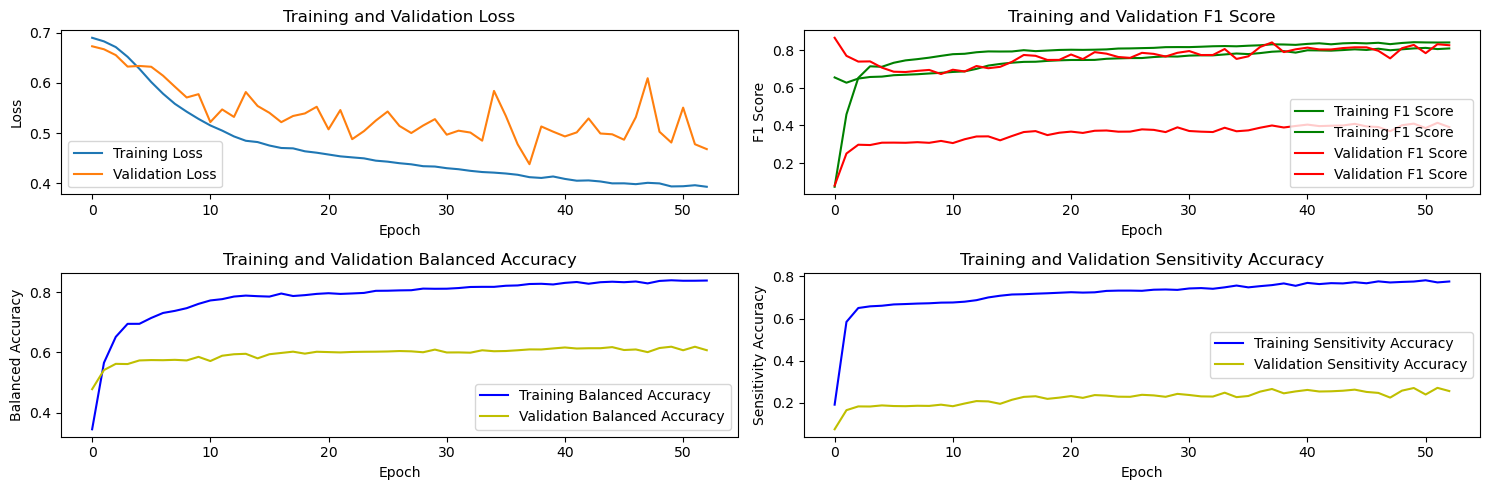

Train - Loss: 0.3935
Test  - Val Loss: 0.4683
Train - Mean F1 Score: 0.7653
Test - Mean Val F1 Score: 0.5623
Train - Final Sensitivity: 0.7755
Test - Final Val Sensitivity: 0.2565
Train - Final Balanced Accuracy: 0.8382
Test - Final Val Balanced Accuracy: 0.6074
870 381


In [13]:
# Synthetic Minority Over-sampling Technique with Alex NN
from imblearn.over_sampling import SMOTE

#It uses SMOTE to oversample the minority class, adjusting the number of samples for each class.
def oversample_data(train_images, train_labels):
    smote = SMOTE(sampling_strategy='auto')
    train_images_reshaped = train_images.reshape(-1, 28*28*3)  # Reshape images for SMOTE
    train_images_oversampled_reshaped, train_labels_oversampled = smote.fit_resample(train_images_reshaped, train_labels)
    train_images_oversampled = train_images_oversampled_reshaped.reshape(-1, 28, 28, 3)  # Reshape back to original shape
    return train_images_oversampled, train_labels_oversampled

X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = oversample_data(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)
train_labels, train_images, test_images, test_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
#plot_images(10, train_images_s_oversampled)

MLP_oversampled = Convolution_NN_2()
Compile_MLP_categorical_crossentropy(MLP_oversampled)
history_oversampled = train_model_class_weights(MLP_oversampled, train_images, train_labels, test_images, test_labels, 0)
check_results(history_oversampled)
check_imbalance(MLP_oversampled, test_images)

Split X_train:  (5003, 2352)
Split y_train:  (5003,)


2023-10-21 16:51:47.264514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


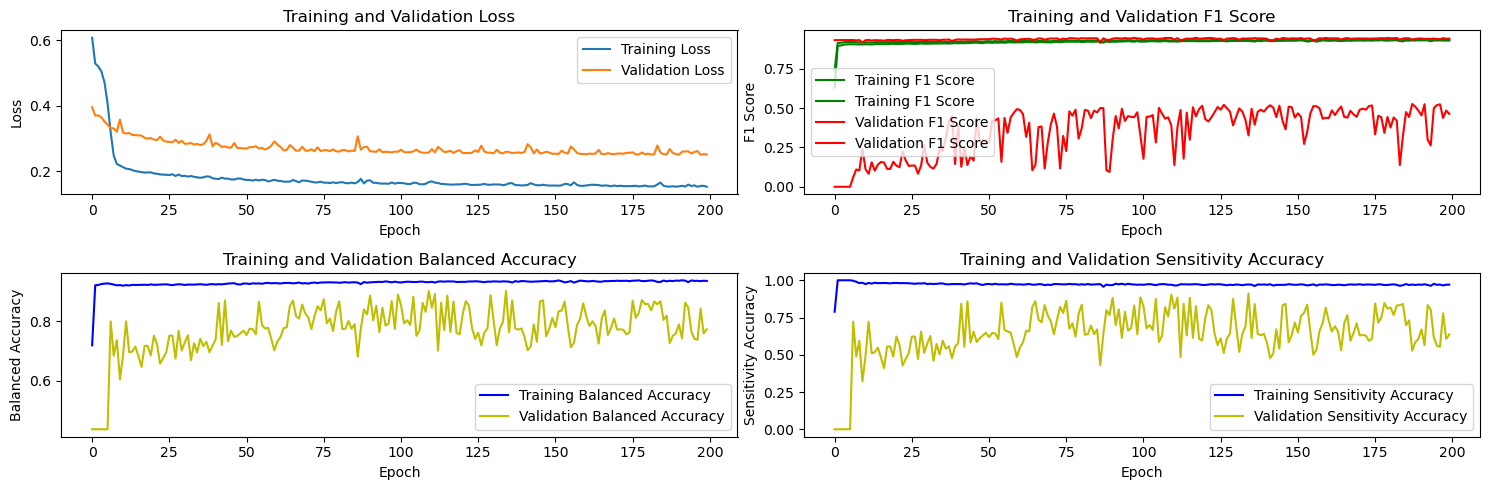

Train - Loss: 0.1520
Test  - Val Loss: 0.2506
Train - Mean F1 Score: 0.9236
Test - Mean Val F1 Score: 0.6469
Train - Final Sensitivity: 0.9708
Test - Final Val Sensitivity: 0.6361
Train - Final Balanced Accuracy: 0.9351
Test - Final Val Balanced Accuracy: 0.7725
1164 87


In [3]:
#REDE 1 - BALANCED
def balance_augmentation(x, y):
    
    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])


    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma

    #choosing to augment only the underrepresented class of data
    if difference >0:           
       
        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment

    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)

    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])

    #generating data
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=10, seed=1000): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] >= difference:
            break
    
    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])

    return balanced_x, balanced_y

X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = balance_augmentation(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)
train_labels, train_images, test_images, test_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)

NN_model = Convolution_NN_1()
Compile_MLP_categorical_crossentropy(NN_model)
history = NN_model.fit(train_images, train_labels, validation_data=(test_images, test_labels), batch_size=512, epochs=200, shuffle=True, verbose=0)
check_results(history)
check_imbalance(NN_model, test_images)

def plot_images2(number_images, X_train):
    '''Plot a user-defined number of images from X_train. Works for any number of images.'''
    height, width, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]  # Define height, width, and channels based on the shape of X_train
    rows = int(np.ceil(number_images / 10))  # Calculate the number of rows based on the desired number of images
    plt.figure(figsize=(12, 6))
    for i in range(number_images):
        plt.subplot(rows, 10, i + 1)
        
        # Reshape the image if needed (e.g., if it's a flattened image)
        if X_train[i].shape != (height, width, channels):
            reshaped_image = np.reshape(X_train[i], (height, width, channels))
        else:
            reshaped_image = X_train[i]
        
        # Normalize the image data to [0, 1] range
        normalized_image_data = reshaped_image.astype(float) / 255.0
        
        if np.min(normalized_image_data) < 0 or np.max(normalized_image_data) > 1:
            raise ValueError("Image data is not in the [0, 1] range.")
        
        plt.imshow(normalized_image_data)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#plot_images2(100, train_images)

Split X_train:  (5003, 2352)
Split y_train:  (5003,)


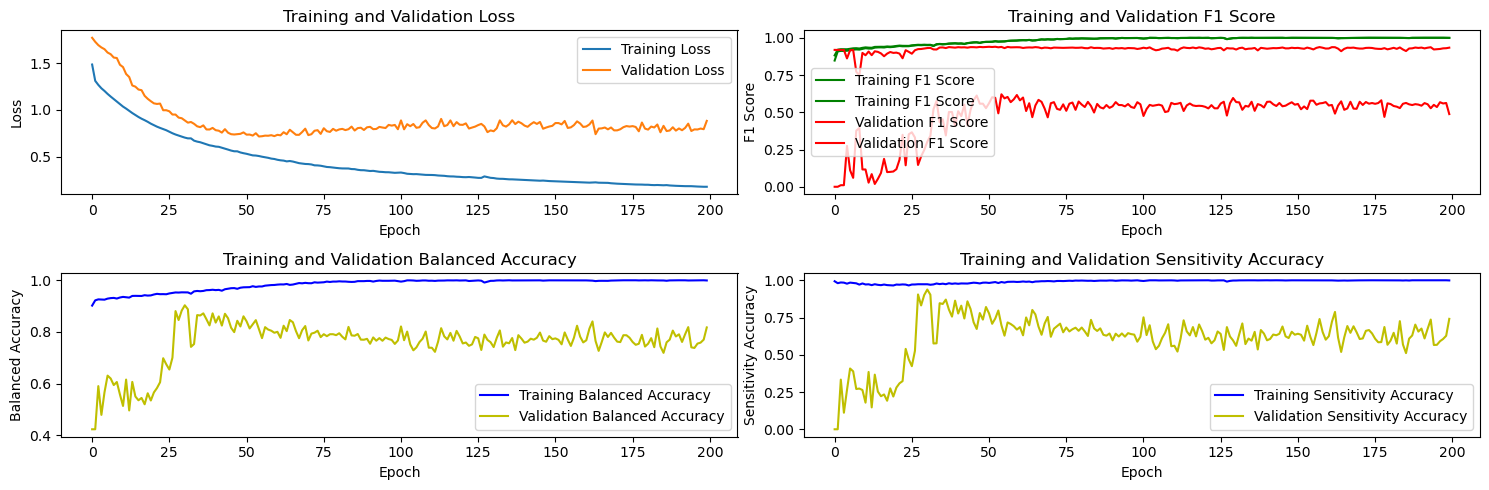

Train - Loss: 0.1755
Test  - Val Loss: 0.8828
Train - Mean F1 Score: 0.9830
Test - Mean Val F1 Score: 0.7037
Train - Final Sensitivity: 0.9991
Test - Final Val Sensitivity: 0.7411
Train - Final Balanced Accuracy: 0.9993
Test - Final Val Balanced Accuracy: 0.8176
1152 99


In [4]:
#REDE 4 - ALEX - BALANCED
def balance_augmentation(x, y):
    
    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])


    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma

    #choosing to augment only the underrepresented class of data
    if difference >0:           
       
        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment

    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)

    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])

    #generating data
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=10, seed=1000): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] >= difference:
            break
    
    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])

    return balanced_x, balanced_y

X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = balance_augmentation(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)
train_labels, train_images, test_images, test_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)

NN_model = Convolution_NN_4()
Compile_MLP_categorical_crossentropy(NN_model)
history = NN_model.fit(train_images, train_labels, validation_data=(test_images, test_labels), batch_size=512, epochs=200, shuffle=True, verbose=0)
check_results(history)
check_imbalance(NN_model, test_images)

def plot_images2(number_images, X_train):
    '''Plot a user-defined number of images from X_train. Works for any number of images.'''
    height, width, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]  # Define height, width, and channels based on the shape of X_train
    rows = int(np.ceil(number_images / 10))  # Calculate the number of rows based on the desired number of images
    plt.figure(figsize=(12, 6))
    for i in range(number_images):
        plt.subplot(rows, 10, i + 1)
        
        # Reshape the image if needed (e.g., if it's a flattened image)
        if X_train[i].shape != (height, width, channels):
            reshaped_image = np.reshape(X_train[i], (height, width, channels))
        else:
            reshaped_image = X_train[i]
        
        # Normalize the image data to [0, 1] range
        normalized_image_data = reshaped_image.astype(float) / 255.0
        
        if np.min(normalized_image_data) < 0 or np.max(normalized_image_data) > 1:
            raise ValueError("Image data is not in the [0, 1] range.")
        
        plt.imshow(normalized_image_data)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#plot_images2(100, train_images)

In [6]:

def print_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

rounded_predictions = make_predictions(NN_model, test_images) 
print_confusion_matrix(test_labels, rounded_predictions, labels=["Class 0", "Class 1"])

: 